# Landsat Multi-Temporal rcs

In remote sensing, we usually work on single images ("scenes") acquired on a given date over a given area. While this sufficient or even necessary for many applications such as the studying of vegetation dynamics, some applications actually require information combined from many scenes, i.e., multiple "snapshots" of an area over time.

Single scenes tend to be noisy mostly because of atmospheric disturbances and instrumentation errors. Thus single scenes might contain significant parts of no-data or poor-quality pixels due to instrument failures, clouds (in the case of optical imagery) or shadows. Taking multiple scenes acquired at different points in time and aggregating them over time by a statistical measure such as the mean or median is therefore in some cases the preferred choice.

Multi-temporal composites are used for many different applications, including

* inputs for classification tasks such as land use/ land cover mapping
* generation of equidistant time series
* generation of basemaps

to name a few.

In this notebook, you will learn how to generate a multi-temporal mosaic
The steps are:

1. We fetch the Landsat scenes overlapping our study region
2. We aggregate the Landsat scenes into a single multi-temporal composite using the median


## Imports and Functions

In [2]:
# we have to install the development version for the time being
#%pip uninstall eodal -y
#%pip install git+https://github.com/lukasValentin/eodal@landsat-dev
#%pip install openpyxl

# required imports
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from pathlib import Path
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
from eodal.config import get_settings
from eodal.core.sensors import Landsat
from eodal.core.scene import SceneCollection
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs
from eodal.core.band import Band
from eodal.core.raster import RasterCollection

# the function to mask clouds and shadows:
def prepocess_landsat_scene(
        ds: Landsat
) -> Landsat:
    """
    Mask clouds and cloud shadows in a Landsat scene based
    on the 'qa_pixel' band.

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
        interfacing libraries!

    :param ds:
        Landsat scene before cloud mask applied.
    :return:
        Landsat scene with clouds and cloud shadows masked.
    """
    ds.mask_clouds_and_shadows(inplace=True)
    return ds

# functions to plot:
def scatterplot_temporal_distribution(metadata_gdf, filtered_metadata_gdf, save_path, year):

    # Convert lists in 'instruments' column to strings
    metadata_gdf['instruments_str'] = metadata_gdf['instruments'].apply(lambda x: ', '.join(map(str, x)))
    filtered_metadata_gdf['instruments_str'] = filtered_metadata_gdf['instruments'].apply(lambda x: ', '.join(map(str, x)))
    
    # Convert 'sensing_date' to datetime type if it's not already
    metadata_gdf['sensing_date'] = pd.to_datetime(metadata_gdf['sensing_date'], errors='coerce')
    filtered_metadata_gdf['sensing_date'] = pd.to_datetime(filtered_metadata_gdf['sensing_date'], errors='coerce')

    # Count number of acquisitions 
    acquisitions = metadata_gdf['sensing_date'].nunique()

    # Plotting using the scatter plot with figsize parameter
    fig, ax = plt.subplots(figsize=(12, 3))

    # Plotting the original data
    metadata_gdf.plot.scatter(x='sensing_date', y='instruments_str', ax=ax, color='blue', label='All Acquisitions')

    # Plotting the filtered data with different color
    filtered_metadata_gdf.plot.scatter(x='sensing_date', y='instruments_str', ax=ax, color='red', label='Acquisitions of interest')

    # Set x-axis limits to cover the entire year
    start_date = pd.to_datetime(metadata_gdf['sensing_date'].min()).replace(day=1, month=1)
    end_date = pd.to_datetime(metadata_gdf['sensing_date'].max()).replace(day=31, month=12)
    ax.set_xlim(start_date, end_date)

    # Customize x-axis ticks to show all months
    months = pd.date_range(start=start_date, end=end_date, freq='M').strftime('%b')
    ax.set_xticklabels(months)

    # Adding labels and title
    plt.xlabel('Sensing Date')
    plt.ylabel('Instruments')
    plt.title(f'Temporal distribution of all {acquisitions} acquisitions in year {year}')

    # Rotate x-axis labels for better readability
    # plt.xticks(rotation=45)

    # Save plot to the specified path
    # fig.savefig(save_path)

def plot_geo_barplot(metadata_gdf, save_path):
    
    # Convert lists in 'instruments' column to strings
    metadata_gdf['instruments_str'] = metadata_gdf['instruments'].apply(lambda x: ', '.join(map(str, x)))
    
    # Convert 'sensing_date' to datetime format
    metadata_gdf['sensing_date'] = pd.to_datetime(metadata_gdf['sensing_date'])
    
    # Extract the year from the 'sensing_date' column
    metadata_gdf['year'] = metadata_gdf['sensing_date'].dt.year

    # Create a complete list of years
    all_years = range(metadata_gdf['year'].min(), metadata_gdf['year'].max() + 1)

    # Group by year and instrument_str, count the number of rows, and unstack
    grouped_data = metadata_gdf.groupby(['year', 'instruments_str']).size().unstack(fill_value=0)

    # Reindex the grouped data with all years
    grouped_data = grouped_data.reindex(all_years, fill_value=0)

    # Plotting with figsize parameter
    fig, ax = plt.subplots(figsize=(16, 9))
    grouped_data.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Rows')
    ax.set_title('Number of Rows by Year and Instrument')
    ax.legend(title='Instrument', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Save plot to the specified path
    #fig.savefig(save_path)
    
# Median and Median Absolute Deviation (mad) by spectral band
def plot_bands_median_mad(rc, colormap_dict, save_path='plots/median_mad.png'):
    # Create subplots
    fig, axs = plt.subplots(6, 2, figsize=(16, 40), sharey=True)

    bands = ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
    stats = ['median', 'mad']

    for i, band in enumerate(bands):
        for j, stat in enumerate(stats):
            column_name = f'{band}_{stat}'
            colormap_key = f'{column_name}'
            
            # Plot band_median and band_mad
            rc.plot_band(column_name, colormap=colormap_dict[colormap_key], ax=axs[i, j])
            axs[i, j].set_title(f'{column_name}', fontsize=15)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Save plot to the specified path
    #fig.savefig(save_path)

# Mean and coefficient of variation (cov) by spectral band
def plot_bands_mean_cov(rc, colormap_dict, save_path='plots/mean_cov.png'):
    # Create subplots
    fig, axs = plt.subplots(6, 2, figsize=(16, 40), sharey=True)

    bands = ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
    stats = ['mean', 'cov']

    for i, band in enumerate(bands):
        for j, stat in enumerate(stats):
            column_name = f'{band}_{stat}'
            colormap_key = f'{column_name}'
            
            # Plot band_median and band_mad
            rc.plot_band(column_name, colormap=colormap_dict[colormap_key], ax=axs[i, j])
            axs[i, j].set_title(f'{column_name}', fontsize=15)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Save plot to the specified path
    #fig.savefig(save_path)

# RGB of the medians and Skewness by band
def plot_bands_skew(rc, colormap_dict, save_path='plots/rgb_skew.png'):
    # Create subplots
    fig, axs = plt.subplots(6, 2, figsize=(16, 40), sharey=True)

    skew_bands = ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
    stats = 'skew'

    for i, skew_band in enumerate(skew_bands):
                # Plot RGB and band_skew
                rc.plot_multiple_bands(["red_median", "green_median", "blue_median"], ax=axs[i, 0])
                axs[i, 0].set_title("red_median, green_median, blue_median", fontsize=15)
                
                rc.plot_band(f'{skew_band}_{stats}', colormap=colormap_dict[f'{skew_band}_{stats}'], ax=axs[i, 1])
                axs[i, 1].set_title(f'{skew_band}_{stats}', fontsize=15)
                break

    # Show the plot
    plt.show()

    # Save plot to the specified path
    #fig.savefig(save_path)

# RGB of the medians and the Spectral indices
def plot_rgb_and_spectral_indices(rc, rc_clean, spectral_indices, colormap_dict, save_path='plots/rgb_si.png'):
    # Create subplots
    fig, axs = plt.subplots(len(spectral_indices), 2, figsize=(16, 16), sharey=True)

    # Iterate over spectral_indices
    for i, index in enumerate(spectral_indices):
        # Plot RGB
        rc.plot_multiple_bands(["red_median", "green_median", "blue_median"], ax=axs[i, 0])
        axs[i, 0].set_title("red_median, green_median, blue_median", fontsize=15)

        # Plot spectral index
        rc_clean.plot_band(index, colormap=colormap_dict[index], ax=axs[i, 1])
        axs[i, 1].set_title(index, fontsize=15)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Save plot to the specified path
    #fig.savefig(save_path)

# RGB of the medians and numbers of observation contributing to the composite
def plot_rgb_and_scene_count(rc, colormap_dict, save_path='plots/rgb_count.png'):

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 16), sharey=True)

    # Plot RGB
    rc.plot_multiple_bands(["red_median", "green_median", "blue_median"], ax=axs[0])
    axs[0].set_title("red_median, green_median, blue_median", fontsize=15)

    # Plot scene_count
    rc.plot_band('scene_count', colormap=colormap_dict['scene_count'], ax=axs[1])
    axs[1].set_title('scene_count', fontsize=15)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Save plot to the specified path
    #fig.savefig(save_path)

## User inputs

base directory:  \\ites-sr.ethz.ch\Satellites\Hiwi_23_TimckeFinn\Landsat-composites
shapefile directory:  \\ites-sr.ethz.ch\Satellites\Hiwi_23_TimckeFinn\Landsat-composites\shapefiles
output geotiff directory:  \\ites-sr.ethz.ch\Satellites\Hiwi_23_TimckeFinn\Landsat-composites\outputs\geotiff
output metadata directory:  \\ites-sr.ethz.ch\Satellites\Hiwi_23_TimckeFinn\Landsat-composites\outputs\metadata

area of interest: knp_boundary_1.shp
Start year: 1982
End year: 2024

Number of Landsat scenes found for the entire time periode 1982-2024: 2246


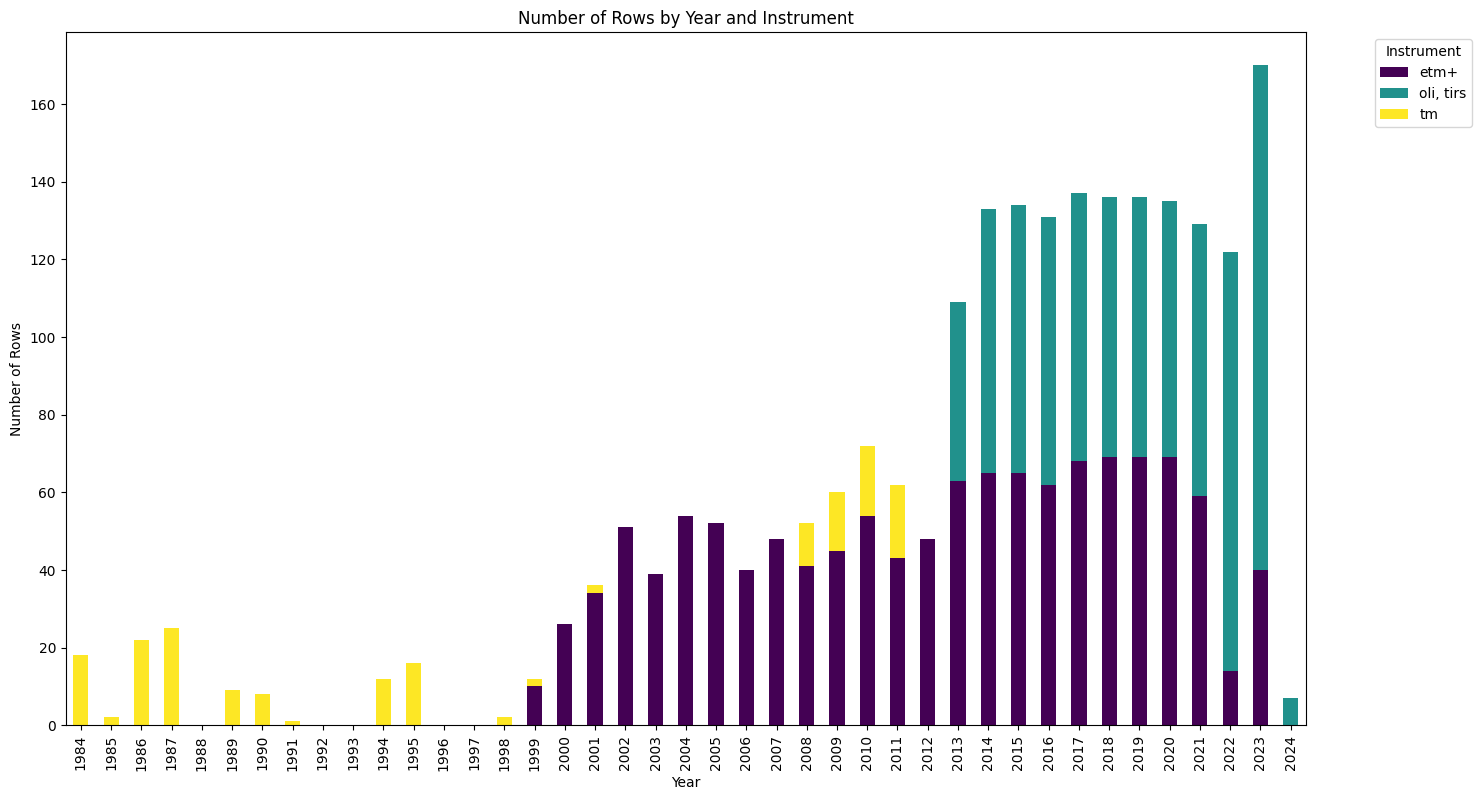

In [3]:
# ------------------------- start of user-inputs ---------------------------
# set and print directories
base_dir: Path = Path('./')
shapefiles_dir: Path = Path(base_dir.joinpath("shapefiles")) # replace "shapefiles" with the actual folder where the shapefiles are located
output_dir: Path = Path(base_dir.joinpath("outputs")) # replace  with the actual folder where you want to save all the different outputs
output_geotiff_dir: Path = Path(output_dir.joinpath("geotiff")) # replace with the actual folder where you want to save the geotiff
output_metadata_dir: Path = Path(output_dir.joinpath("metadata")) # replace with the actual folder where you want to save the metadata
output_html_dir: Path = Path(output_dir.joinpath("html")) # replace with the actual folder where you want to save the HTML

# ------------------------- Spatial Filters ---------------------------
shapefile_name = "knp_boundary_1.shp" #choose a shapefile from the 'shapefiles' folder with the extension '.shp' !

# ------------------------- Timeinterval Filters ---------------------------
year_start = 1982
year_end = 2024

month_start = 1 # must be smaller than month_end
month_end = 12 # must be higher than month_start

# ------------------------- Metadata Filters ---------------------------
metadata_filters = [
    #Cloud cover threshold?    
    #Filter('eo:cloud_cover', '<=', 30),

    #Sensors to exclude?
    #Filter('instruments', '!=', 'tm'),
    #Filter('instruments', '!=', 'etm+'),
    #Filter('instruments', '!=', 'oli')
]

# spectral_indices to be added
spectral_indices = [

    'NDVI',
    'EVI',
    #'CI_GREEN', 
    #'MSAVI',
    #'NDWI',
    'BSI'
]
# ------------------------- end of user-inputs ---------------------------

# prints the directories and output locations
print('base directory: ', base_dir.resolve())
print('shapefile directory: ', shapefiles_dir.resolve())
print('output geotiff directory: ', output_geotiff_dir.resolve())
print('output metadata directory: ', output_metadata_dir.resolve())
print()
print('area of interest:', shapefile_name)
print('Start year:', year_start)
print('End year:', year_end)
print()

# setting up the EOdal Mapper
Settings = get_settings()

# Increase the maximum item number if the limit is reached: mapper.metadata.shape[0]
Settings.MAX_ITEMS  = 3000

# we use STAC, i.e., Microsoft Planetary Computer
Settings.USE_STAC = True

# -------------------------- Collection -------------------------------
collection = 'landsat-c2-l2'

# ---------------------- Spatial Feature  ------------------------------
geom: Path = Path(shapefiles_dir.joinpath(shapefile_name))
feature = Feature.from_geoseries(gpd.read_file(geom).dissolve().geometry)

# ------------------------- Time Range ---------------------------------
time_start = datetime(year_start, 1, 1)
time_end = datetime(year_end, 12, 31)

# set up the Mapper configuration
mapper_configs = MapperConfigs(
    metadata_filters=metadata_filters,
    collection=collection,
    feature=feature,
    time_start=time_start,
    time_end=time_end)

# get a new mapper instance
mapper = Mapper(mapper_configs)

# query the collection for scenes
mapper.query_scenes()

print(f'Number of Landsat scenes found for the entire time periode {year_start}-{year_end}: {mapper.metadata.shape[0]}')

# the metadata is stored as a GeoDataFrame "mapper.metadata"
# create copy to plot it
metadata_gdf = mapper.metadata

# Convert the 'timestamp' column to timezone-unaware datetimes
metadata_gdf['sensing_time'] = metadata_gdf['sensing_time'].dt.tz_localize(None)

# Save metadata as xlsx-file
output_file_path = output_metadata_dir.joinpath(f'scenes_metadata_{shapefile_name[:-4]}_{year_start}-{year_end}.xlsx')
metadata_gdf.to_excel(output_file_path, index=True)

# Assuming metadata_gdf is defined somewhere in your code
# Call the function with the appropriate parameters
plot_geo_barplot(metadata_gdf, save_path=f'plots/barplot_temporal_distribution_total_{year_start}-{year_end}.png')

## Show the scene distribution for time interval of interest

### Plot the temporal distribution of all acquisitions and highlight those within the months of interest

Start year: 1982
End year: 2024

EOdal will extract data for 36 timeintervals and aggragate all available scenes within that timeinterval to one composite: 

Timeinterval 1: Number of Landsat scenes found in year 1984: 18 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 2: Number of Landsat scenes found in year 1985: 2 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 3: Number of Landsat scenes found in year 1986: 22 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 4: Number of Landsat scenes found in year 1987: 25 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 5: Number of Landsat scenes found in year 1989: 9 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 6: Number of Landsat scenes found in year 1990: 8 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 7: Number of Landsat scenes found in year 1991: 1 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 8: Number of Landsat scenes found in year 1994: 12 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 9: Number of Landsat scenes found in year 1995: 16 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 10: Number of Landsat scenes found in year 1998: 2 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 11: Number of Landsat scenes found in year 1999: 12 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 12: Number of Landsat scenes found in year 2000: 26 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 13: Number of Landsat scenes found in year 2001: 36 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 14: Number of Landsat scenes found in year 2002: 51 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 15: Number of Landsat scenes found in year 2003: 39 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 16: Number of Landsat scenes found in year 2004: 54 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 17: Number of Landsat scenes found in year 2005: 52 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 18: Number of Landsat scenes found in year 2006: 40 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 19: Number of Landsat scenes found in year 2007: 48 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 20: Number of Landsat scenes found in year 2008: 52 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 21: Number of Landsat scenes found in year 2009: 60 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12, 3))
C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 22: Number of Landsat scenes found in year 2010: 72 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 23: Number of Landsat scenes found in year 2011: 62 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 24: Number of Landsat scenes found in year 2012: 48 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 25: Number of Landsat scenes found in year 2013: 109 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 26: Number of Landsat scenes found in year 2014: 133 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 27: Number of Landsat scenes found in year 2015: 134 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 28: Number of Landsat scenes found in year 2016: 131 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 29: Number of Landsat scenes found in year 2017: 137 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 30: Number of Landsat scenes found in year 2018: 136 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 31: Number of Landsat scenes found in year 2019: 136 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 32: Number of Landsat scenes found in year 2020: 135 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 33: Number of Landsat scenes found in year 2021: 129 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 34: Number of Landsat scenes found in year 2022: 122 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 35: Number of Landsat scenes found in year 2023: 170 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


Timeinterval 36: Number of Landsat scenes found in year 2024: 7 


C:\Users\finnt\AppData\Local\Temp\ipykernel_928\1812332996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


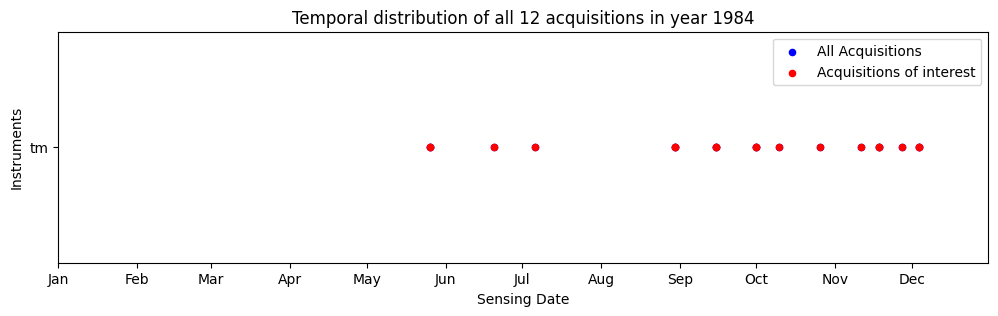

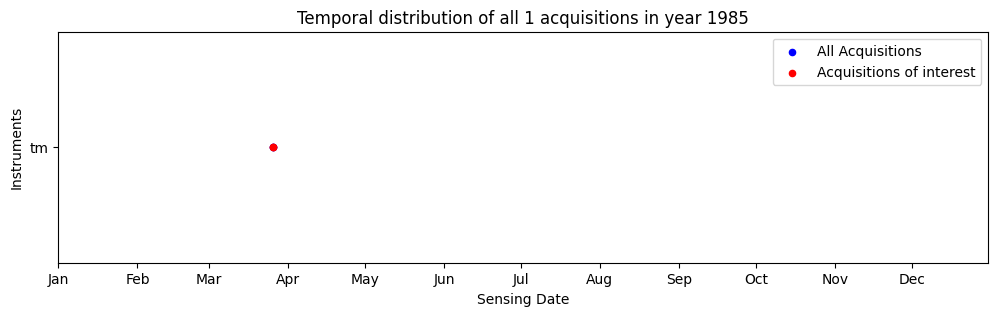

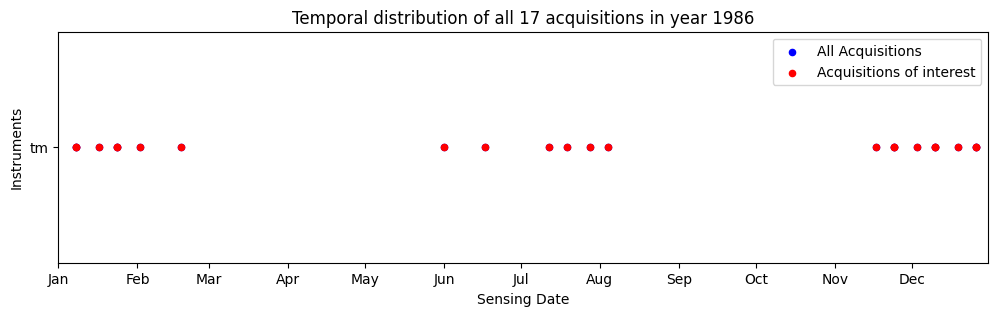

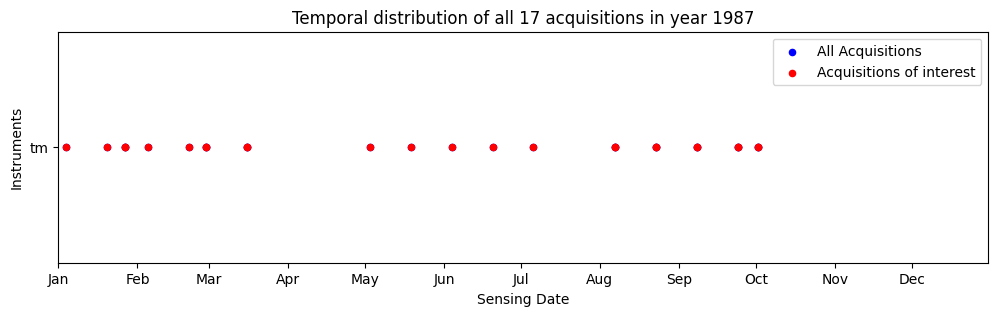

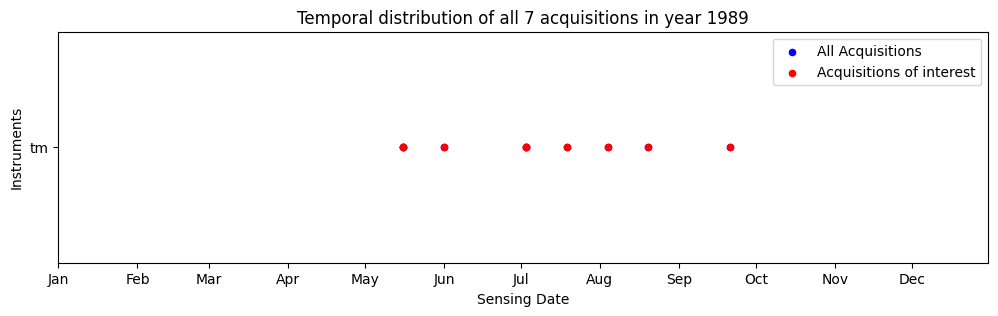

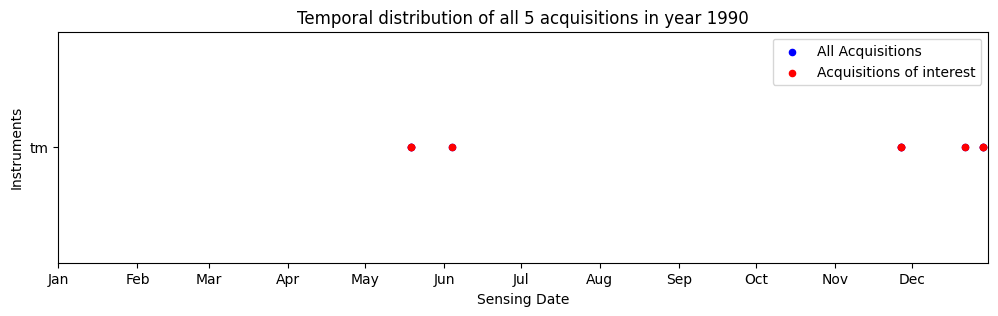

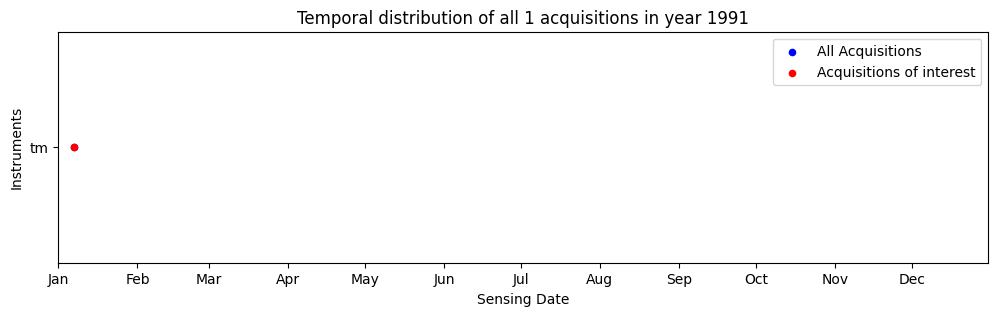

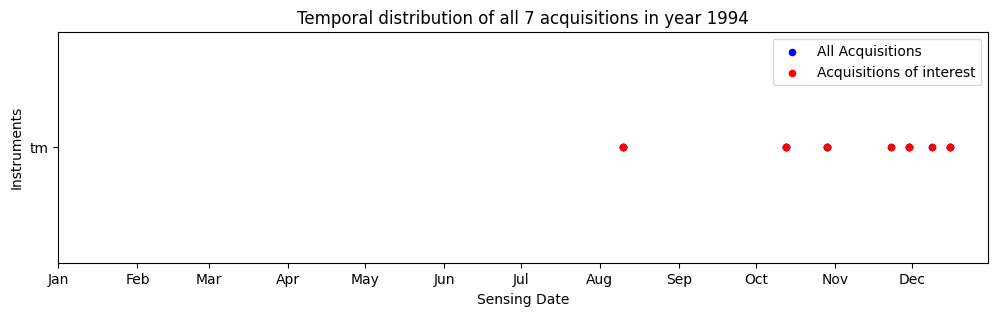

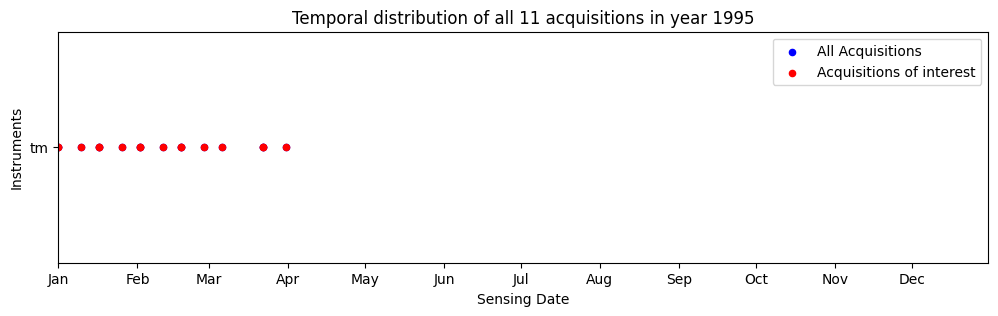

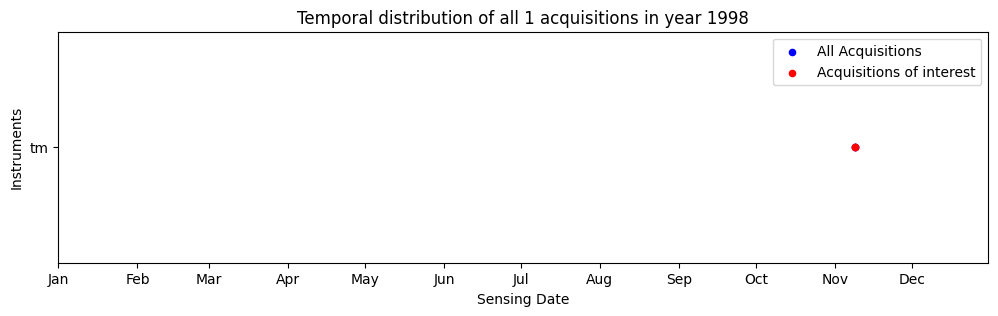

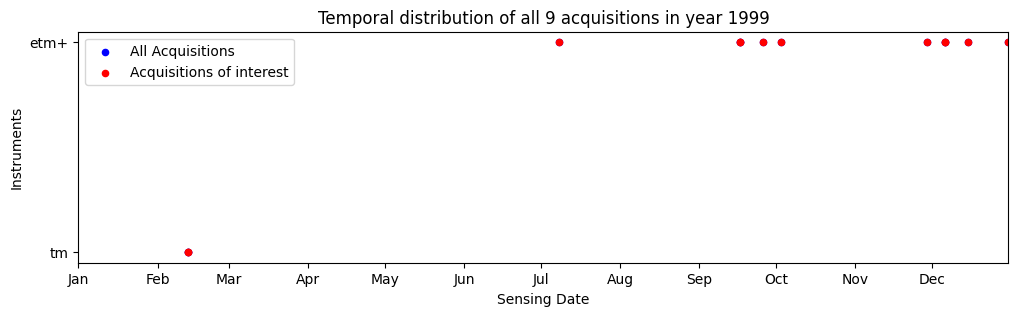

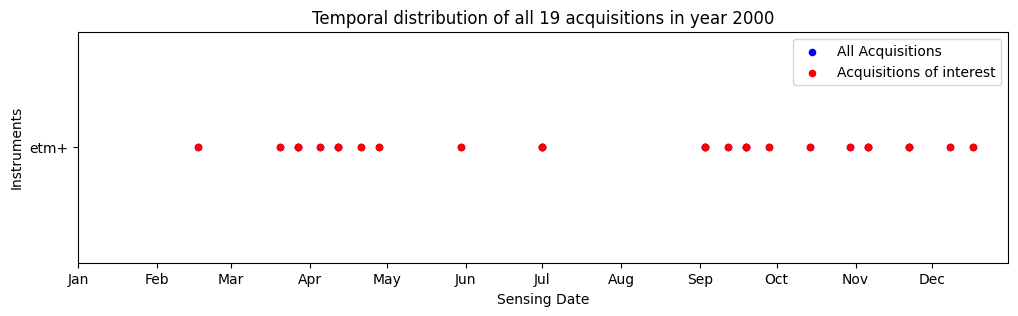

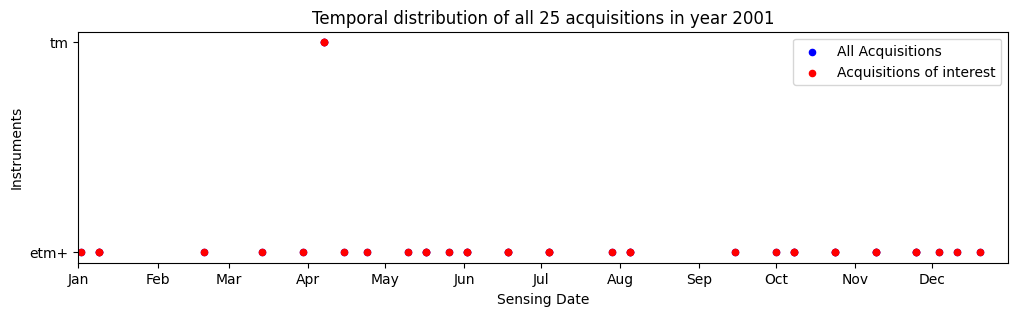

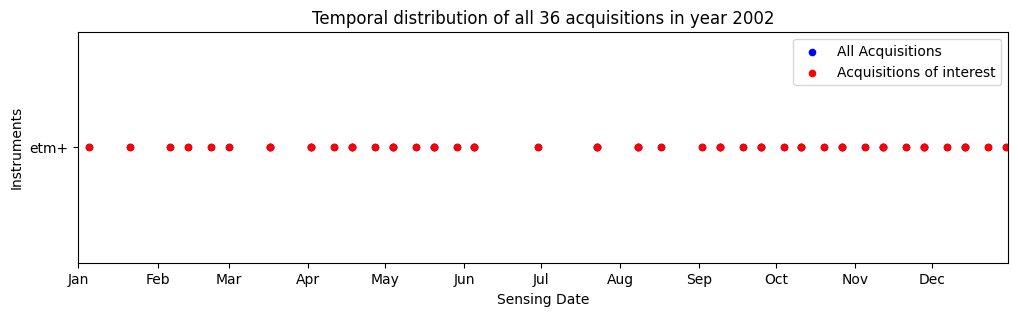

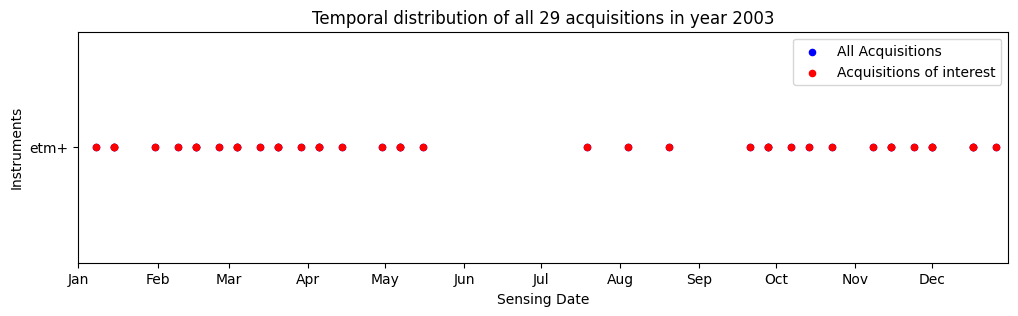

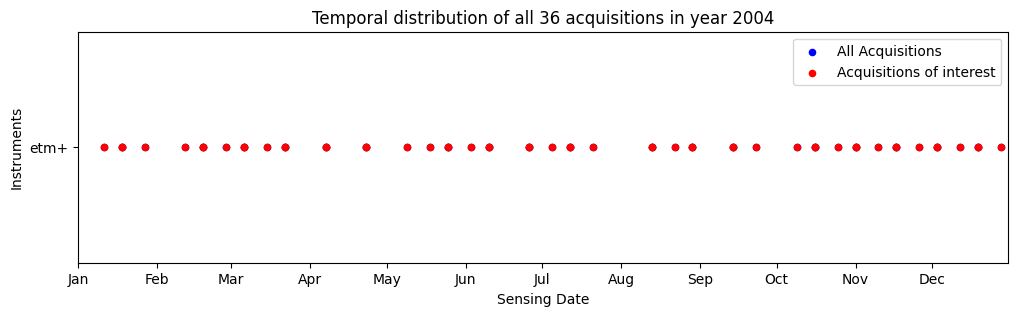

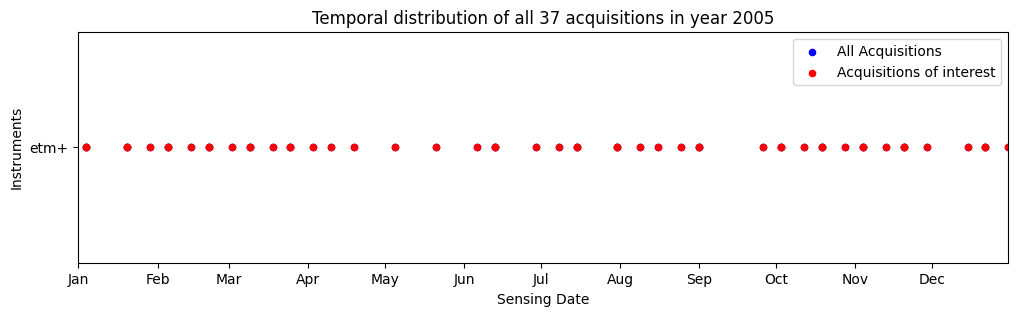

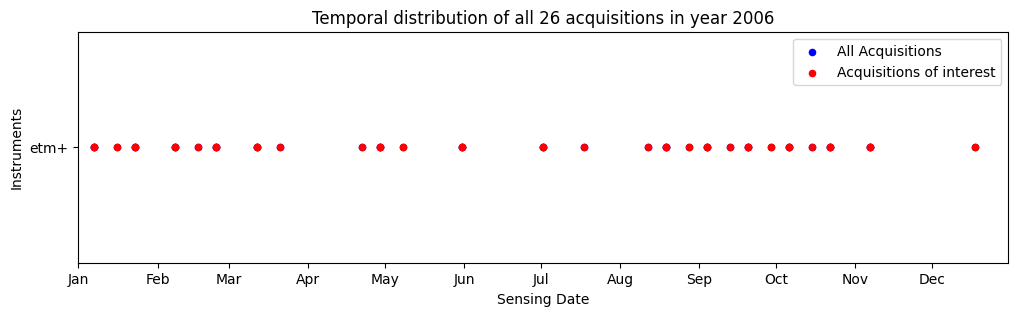

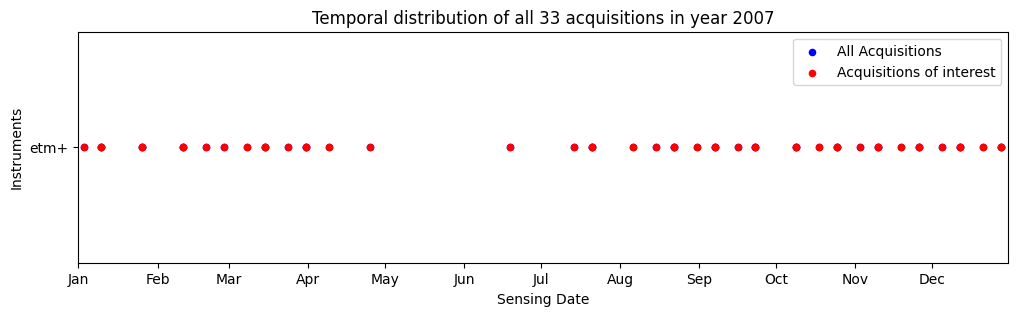

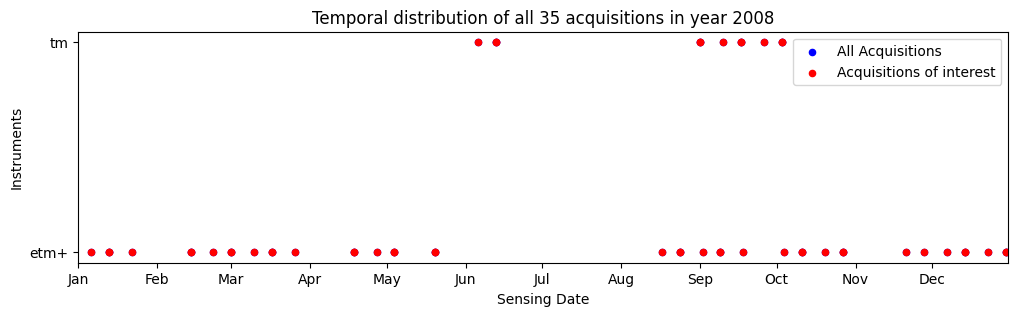

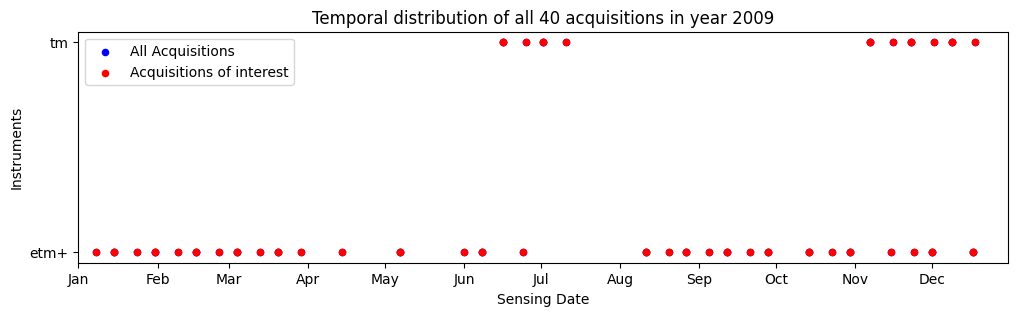

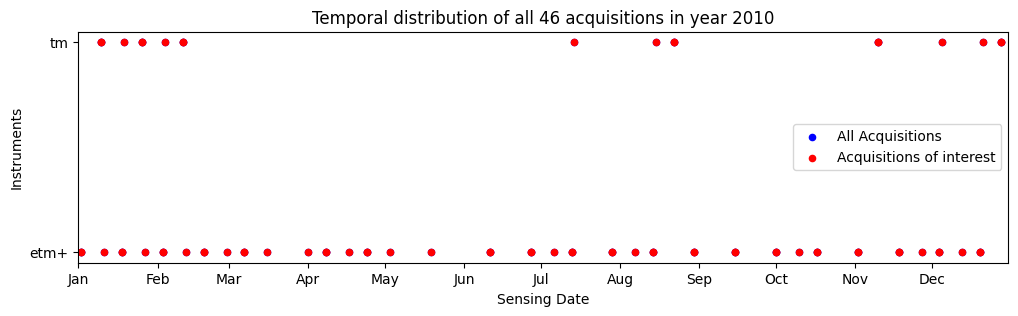

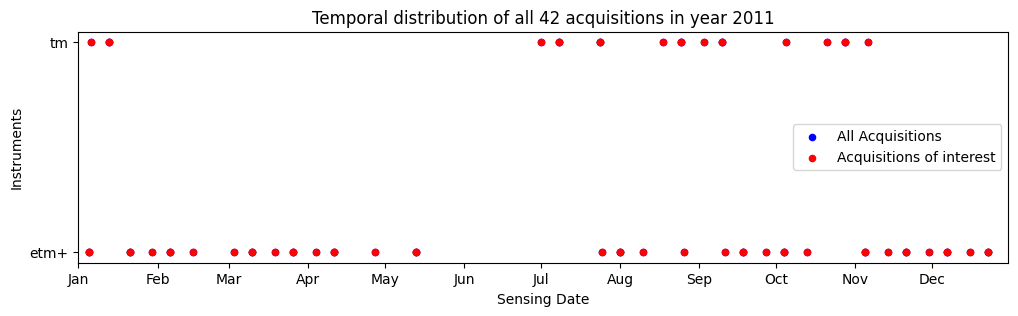

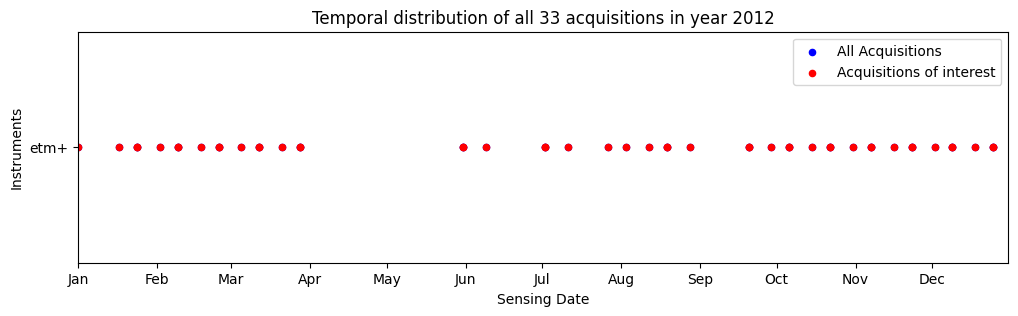

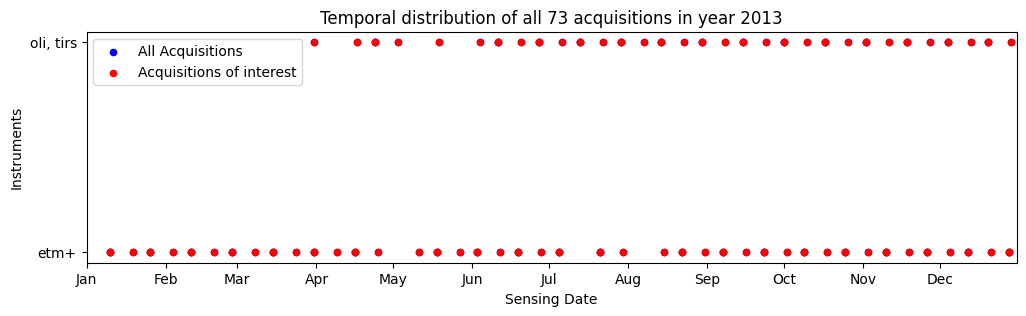

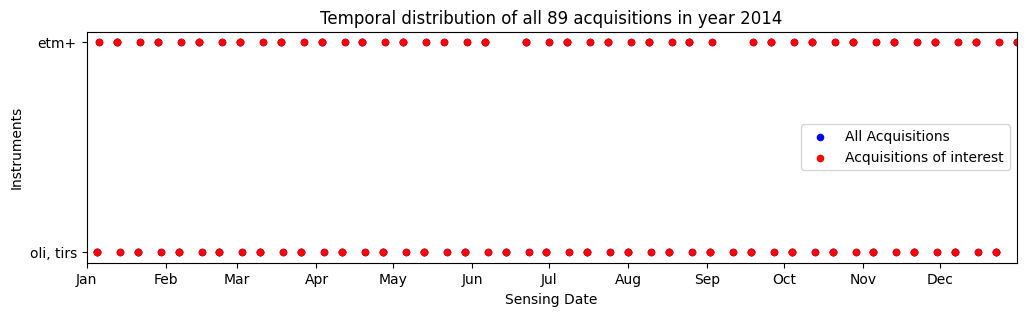

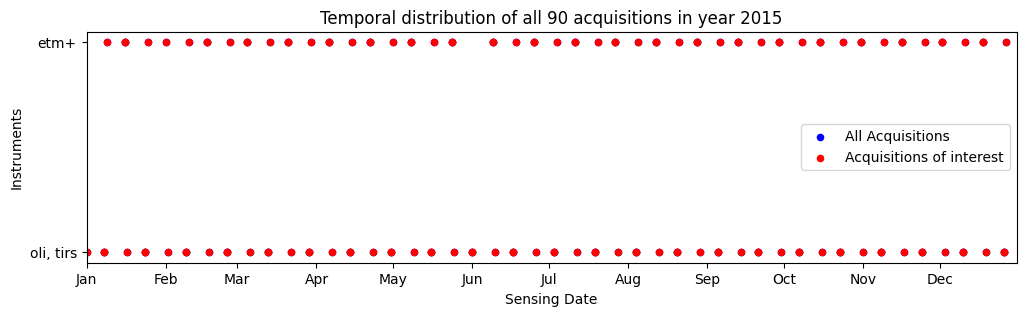

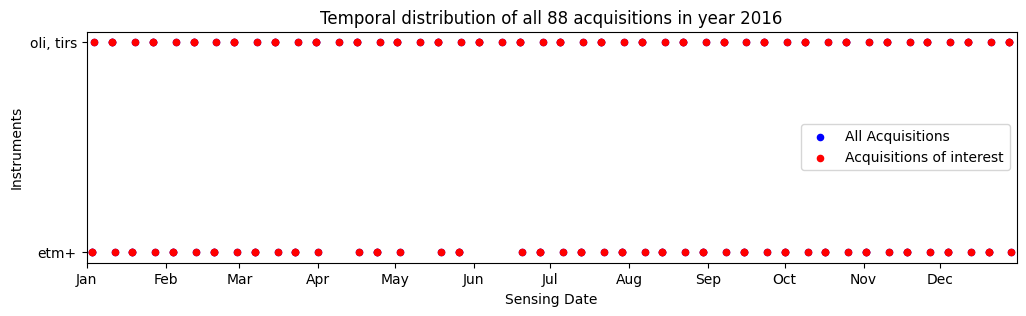

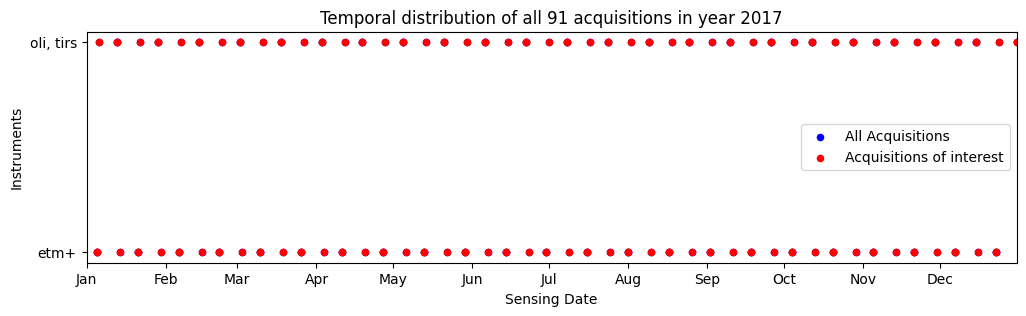

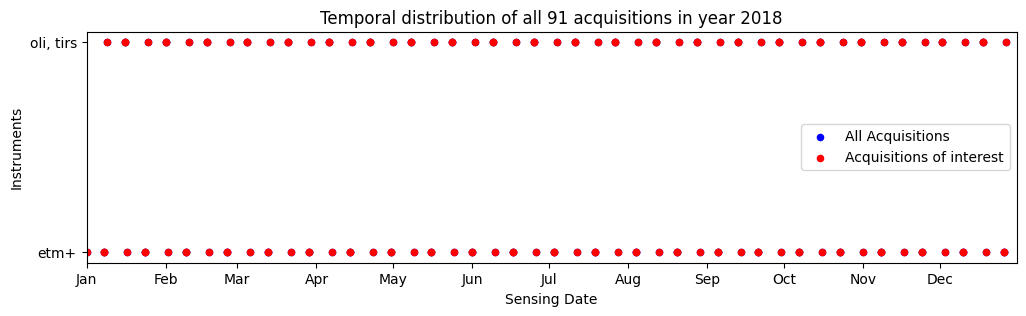

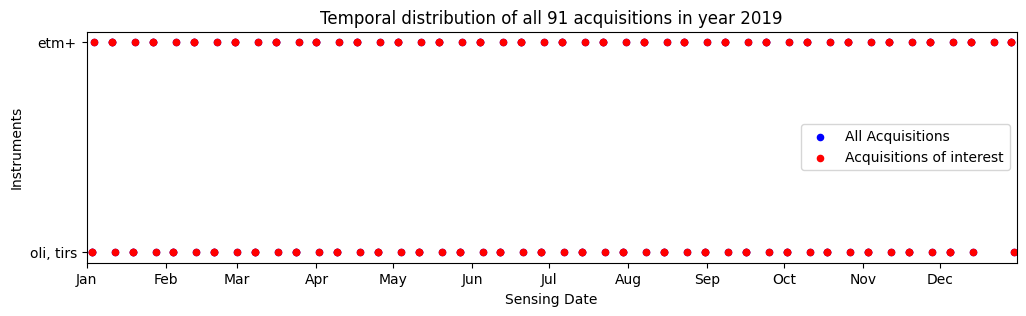

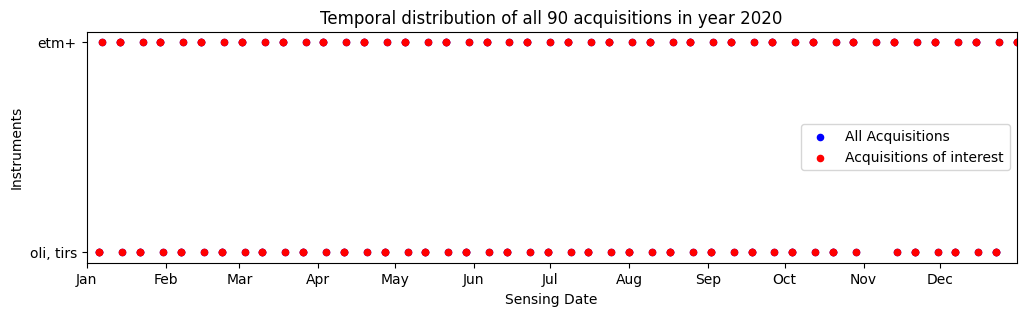

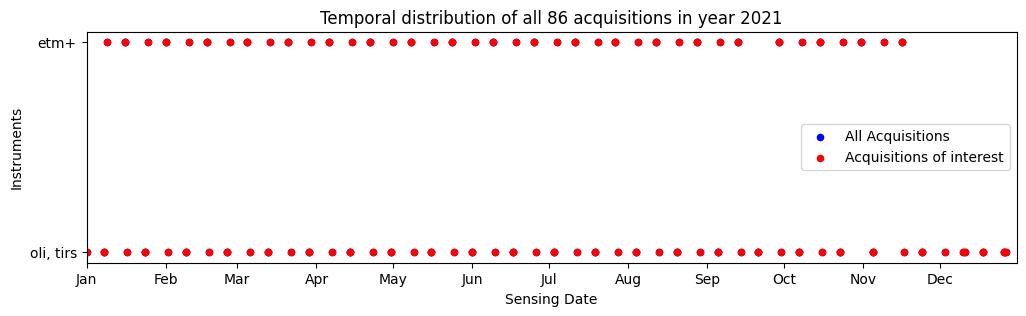

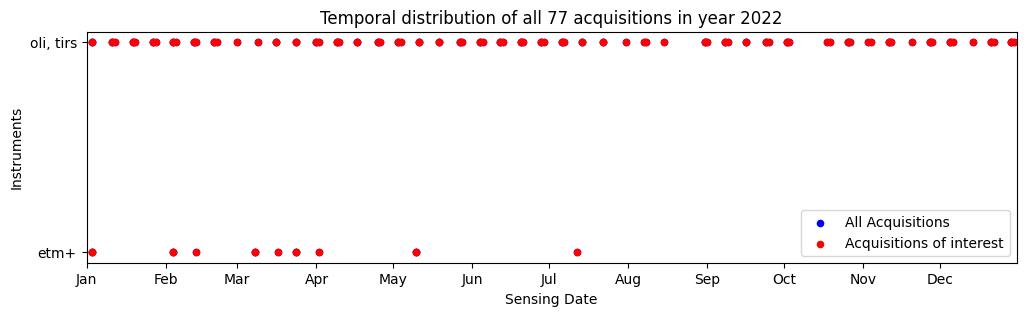

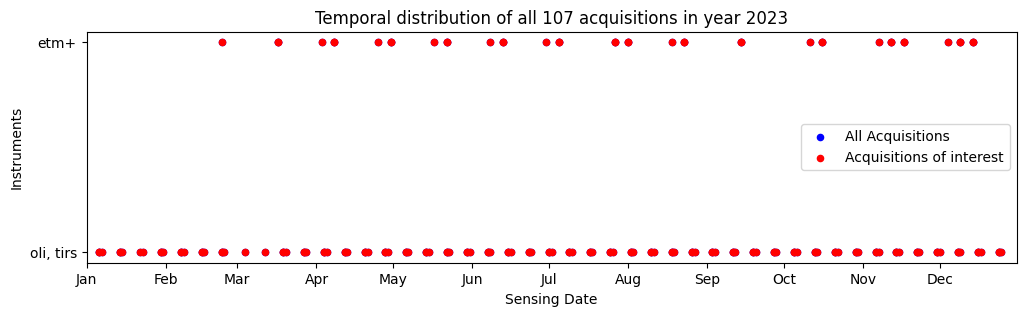

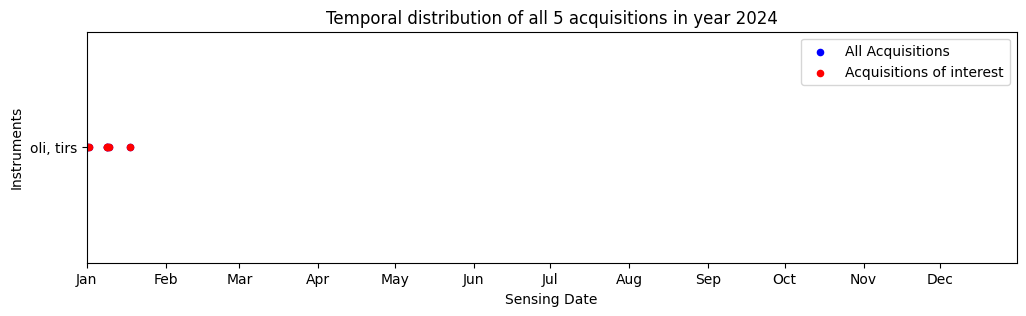

In [4]:
# Extracting year from the 'sensing_date' column
metadata_gdf['year'] = pd.to_datetime(metadata_gdf['sensing_date']).dt.year

# Get a list of all unique years in the dataset
years_with_scenes = list(metadata_gdf['year'].unique())
#print(f'years_with_scenes: {years_with_scenes}')

# Get a list of years without scenes
years_without_scenes = [year for year in range(min(years_with_scenes), max(years_with_scenes) + 1) if year not in years_with_scenes]
#print(f'years_without_scenes: {years_without_scenes}')

print('Start year:', year_start)
print('End year:', year_end)
print()
print(f'EOdal will extract data for {len(years_with_scenes)} timeintervals and aggragate all available scenes within that timeinterval to one composite: ')
print()

month_start = 1 # must be smaller than month_end
month_end = 12 # must be higher than month_start

metadata_gdf = gpd.GeoDataFrame()

for i, year in enumerate(years_with_scenes):
    
    time_start = datetime(year, 1, 1)
    time_end = datetime(year, 12, 31)

    # set up the Mapper configuration
    mapper_configs = MapperConfigs(
        metadata_filters=metadata_filters,
        collection=collection,
        feature=feature,
        time_start=time_start,
        time_end=time_end)

    # get a new mapper instance
    mapper = Mapper(mapper_configs)
    mapper.query_scenes()
    #if mapper.data.is_empty():
    #    continue
    
    print(f'Timeinterval {i+1}: Number of Landsat scenes found in year {year}: {mapper.metadata.shape[0]} ')
    
    # the metadata is stored as a GeoDataFrame "mapper.metadata"
    # create copy to plot it
    metadata_gdf = mapper.metadata

    # Convert start and end dates to datetime.date objects
    start_date = pd.Timestamp(year, month_start, 1).date()
    end_date = pd.Timestamp(year, month_end, pd.Timestamp(year, month_end, 1).days_in_month).date()

    # Filter the DataFrame based on the time interval
    filtered_metadata_gdf = metadata_gdf[(metadata_gdf['sensing_date'] >= start_date) & (metadata_gdf['sensing_date'] <= end_date)]

    # Call the function with the appropriate parameters
    scatterplot_temporal_distribution(metadata_gdf,filtered_metadata_gdf, save_path=f'plots/temporal_distribution_total_{year}.png', year=year)
    
    # Save metadata as an Excel file
    #metadata_gdf.to_excel(output_metadata_dir.joinpath(f'landsat_composite_{shapefile_name[:-4]}_{year}_metadata.xlsx'), index=True)




## Extraction of scenes per time interval and Composite generation

In [5]:
# make sure that there is at least one scene within time_start and time_end, otherwise the code will crash.

import rasterio
import os
import numpy as np
from jinja2 import Environment, FileSystemLoader
from pathlib import Path

for year in years_with_scenes:
    
    # ------------------------- Time Range ---------------------------------
    time_start = datetime(year, month_start, 1)
    time_end = datetime(year, month_end, 31)

    # set up the Mapper configuration
    mapper_configs = MapperConfigs(
        metadata_filters=metadata_filters,
        collection=collection,
        feature=feature,
        time_start=time_start,
        time_end=time_end)

    # get a new mapper instance
    mapper = Mapper(mapper_configs)
    
    # We tell EOdal how to load the Landsat scenes using `Landsat.from_usgs`and pass on some kwargs, e.g., the selection of bands we want to read. 
    # In addition, we tell EOdal to mask out clouds and shadows and the fly while reading the data using the qa_pixel band (therefore, we set the `read_qa` flag to True.
    scene_kwargs = {
        'scene_constructor': Landsat.from_usgs,
        'scene_constructor_kwargs': {
            'band_selection': ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22'],
            'read_qa': True},
        'scene_modifier': prepocess_landsat_scene,
        'scene_modifier_kwargs': {}
        }

    # now we load the scenes
    mapper.load_scenes(scene_kwargs=scene_kwargs)
    
    # the scenes are loaded into a EOdal SceneCollection object "mapper.data"
    # all scenes have the same shape, i.e., the same number of bands, rows and columns
    shapes = [{timestamp: scene.get_values().shape} for timestamp, scene in mapper.data]

    #The mapper returns the single scenes. As we told the EOdal to mask out clouds, a significant share if the pixels is masked out. We will aggregate them in the next step.
    #f = mapper.data.plot(band_selection=['red', 'green', 'blue'], figsize=(10, 20), max_scenes_in_row=3)

    # open arrays for storing the data per band
    shape = (len(mapper.data), list(shapes[0].values())[0][1], list(shapes[0].values())[0][2])
    blue = np.ma.masked_array(data=np.ndarray(shape, dtype=float), mask=False)
    red = np.zeros_like(blue)
    green = np.zeros_like(blue)
    nir08 = np.zeros_like(blue)
    swir16 = np.zeros_like(blue)
    swir22 = np.zeros_like(blue)

    scene_count = np.zeros_like(blue)

    # Next, we loop over the scenes.

    # loop over scenes and store values
    idx = 0
    for _, scene in mapper.data:
        blue[idx, :, :] = scene['blue'].values
        red[idx, :, :] = scene['red'].values
        green[idx, :, :] = scene['green'].values
        nir08[idx, :, :] = scene['nir08'].values
        swir16[idx, :, :] = scene['swir16'].values
        swir22[idx, :, :] = scene['swir22'].values
        
        #scene_count[idx, :, :] = scene['blue'].values
        
        idx += 1
        
    # Finally, we aggregate the data using the median reflectance. 
    # Since we deal with masked arrays, we have to call [numpy.ma.median](https://numpy.org/doc/stable/reference/generated/numpy.ma.median.html) instead of the "normal" numpy.median function.

    # Calculate Spectral-temporal metrics:

    # Calculate the median reflectance per spectral band
    blue_median = np.ma.median(blue, axis=0)
    green_median = np.ma.median(green, axis=0)
    red_median = np.ma.median(red, axis=0)
    nir08_median = np.ma.median(nir08, axis=0)
    swir16_median = np.ma.median(swir16, axis=0)
    swir22_median = np.ma.median(swir22, axis=0)

    # Calculate the median absolute deviation (mad) per spectral band
    # mad = np.median(abs(data - np.median(data))) (https://datagy.io/mean-absolute-deviation-python/)
    blue_mad = ((np.ma.median(np.abs(blue - np.ma.median(blue, axis=0)), axis=0)) / np.ma.median(blue, axis=0)) * 100
    green_mad = ((np.ma.median(np.abs(green - np.ma.median(green, axis=0)), axis=0)) / np.ma.median(green, axis=0)) * 100
    red_mad = ((np.ma.median(np.abs(red - np.ma.median(red, axis=0)), axis=0)) / np.ma.median(red, axis=0)) * 100
    nir08_mad = ((np.ma.median(np.abs(nir08 - np.ma.median(nir08, axis=0)), axis=0)) / np.ma.median(nir08, axis=0)) * 100
    swir16_mad = ((np.ma.median(np.abs(swir16 - np.ma.median(swir16, axis=0)), axis=0)) / np.ma.median(swir16, axis=0)) * 100
    swir22_mad = ((np.ma.median(np.abs(swir22 - np.ma.median(swir22, axis=0)), axis=0)) / np.ma.median(swir22, axis=0)) * 100

    # Calculate the mean reflectance per spectral band
    blue_mean = np.ma.mean(blue, axis=0)
    green_mean = np.ma.mean(green, axis=0)
    red_mean = np.ma.mean(red, axis=0)
    nir08_mean = np.ma.mean(nir08, axis=0)
    swir16_mean = np.ma.mean(swir16, axis=0)
    swir22_mean = np.ma.mean(swir22, axis=0)

    # Calculate the coefficient of variation (cov) per spectral band
    # cov = np.std(data) / np.mean(data) (https://datagy.io/python-coefficient-of-variation/)  
    blue_cov = (np.ma.std(blue, axis=0) / np.ma.mean(blue, axis=0)) * 100
    green_cov = (np.ma.std(green, axis=0) / np.ma.mean(green, axis=0)) * 100
    red_cov = (np.ma.std(red, axis=0) / np.ma.mean(red, axis=0)) * 100
    nir08_cov = (np.ma.std(nir08, axis=0) / np.ma.mean(nir08, axis=0)) * 100
    swir16_cov = (np.ma.std(swir16, axis=0) / np.ma.mean(swir16, axis=0)) * 100
    swir22_cov = (np.ma.std(swir22, axis=0) / np.ma.mean(swir22, axis=0)) * 100

    # Calculate the difference between mean and median, also known as skewness or skew per spectral band
    # skew = np.mean(data) - np.median(data) https://www.turing.com/kb/calculating-skewness-and-kurtosis-in-python#skewness  
    blue_skew = np.ma.mean(blue, axis=0) - np.ma.median(blue, axis=0)
    green_skew = np.ma.mean(green, axis=0) - np.ma.median(green, axis=0)
    red_skew = np.ma.mean(red, axis=0) - np.ma.median(red, axis=0)
    nir08_skew = np.ma.mean(nir08, axis=0) - np.ma.median(nir08, axis=0)
    swir16_skew = np.ma.mean(swir16, axis=0) - np.ma.median(swir16, axis=0)
    swir22_skew = np.ma.mean(swir22, axis=0) - np.ma.median(swir22, axis=0)

    # calculate the pixel count (e.g. for the blue band)
    scene_count = np.ma.count(blue, axis=0)

    # We store the results in a new RasterCollection.
    # save the median reflectance to a new RasterCollection

    ## Create new dictionaries for the metrics bands:
    # median bands (changed the order of the first 3 bands from Landsats default order to match RGB when displayed in ArcGIS Pro)
    median_bands = {'red': red_median, 
                    'green': green_median,
                    'blue': blue_median, 
                    'nir08': nir08_median,
                    'swir16' : swir16_median,
                    'swir22' : swir22_median}

    # mad bands
    mad_bands = {'blue': blue_mad, 
                'green': green_mad, 
                'red': red_mad, 
                'nir08': nir08_mad,
                'swir16' : swir16_mad,
                'swir22' : swir22_mad}

    # mean bands
    mean_bands = {'blue': blue_mean, 
                    'green': green_mean, 
                    'red': red_mean, 
                    'nir08': nir08_mean,
                    'swir16' : swir16_mean,
                    'swir22' : swir22_mean}

    # cov bands
    cov_bands = {'blue': blue_cov, 
                    'green': green_cov, 
                    'red': red_cov, 
                    'nir08': nir08_cov,
                    'swir16' : swir16_cov,
                    'swir22' : swir22_cov}

    # skew bands
    skew_bands = {'blue': blue_skew, 
                    'green': green_skew, 
                    'red': red_skew, 
                    'nir08': nir08_skew,
                    'swir16' : swir16_skew,
                    'swir22' : swir22_skew}

    ## Create new RasterCollection rc:
    rc = RasterCollection()

    ### add bands to RasterCollection rc as new bands:
    # add median bands to rc
    for band_name, band_value in median_bands.items():
        rc.add_band(
            band_constructor=Band,
            values=band_value,
            band_name=f'{band_name}_median',
            geo_info=scene[band_name].geo_info)
        
    # add mad bands to rc
    for band_name, band_value in mad_bands.items():
        rc.add_band(
            band_constructor=Band,
            values=band_value,
            band_name=f'{band_name}_mad',
            geo_info=scene[band_name].geo_info)

    # add mean bands to rc
    for band_name, band_value in mean_bands.items():
        rc.add_band(
            band_constructor=Band,
            values=band_value,
            band_name=f'{band_name}_mean',
            geo_info=scene[band_name].geo_info)
        
    # add cov bands to rc
    for band_name, band_value in cov_bands.items():
        rc.add_band(
            band_constructor=Band,
            values=band_value,
            band_name=f'{band_name}_cov',
            geo_info=scene[band_name].geo_info)
        
    # add skew bands to rc
    for band_name, band_value in skew_bands.items():
        rc.add_band(
            band_constructor=Band,
            values=band_value,
            band_name=f'{band_name}_skew',
            geo_info=scene[band_name].geo_info)
        
    # add pixel count to rc as new band
    rc.add_band(
            band_constructor=Band,
            values=scene_count,
            band_name='scene_count',
            geo_info=scene['blue'].geo_info)

    # add band aliases to the band names, which are used in the calculation of the spectral indices
    rc._band_aliases = ['red', 'green', 'blue', 'nir_1', 'swir_1', 'swir_2',
                        'blue_mad', 'green_mad', 'red_mad', 'nir08_mad', 'swir16_mad', 'swir22_mad', 
                        'blue_mean', 'green_mean', 'red_mean', 'nir08_mean', 'swir16_mean', 'swir22_mean', 
                        'blue_cov', 'green_cov', 'red_cov', 'nir08_cov', 'swir16_cov', 'swir22_cov', 
                        'blue_skew', 'green_skew', 'red_skew', 'nir08_skew', 'swir16_skew', 'swir22_skew', 
                        'scene_count'] + spectral_indices
    # calculate some SI
    for index in spectral_indices:
        rc.calc_si(index, inplace = True)

    # reset to original band aliases
    rc._band_aliases = ['red_median', 'green_median', 'blue_median', 'nir08_median', 'swir16_median', 'swir22_median',
                        'blue_mad', 'green_mad', 'red_mad', 'nir08_mad', 'swir16_mad', 'swir22_mad', 
                        'blue_mean', 'green_mean', 'red_mean', 'nir08_mean', 'swir16_mean', 'swir22_mean', 
                        'blue_cov', 'green_cov', 'red_cov', 'nir08_cov', 'swir16_cov', 'swir22_cov', 
                        'blue_skew', 'green_skew', 'red_skew', 'nir08_skew', 'swir16_skew', 'swir22_skew', 
                        'scene_count'] + spectral_indices

    # save as GeoTiff 
    rc.to_rasterio(f'S:\Hiwi_23_TimckeFinn\outputs\geotiff\Landsat_Composite_{shapefile_name[:-4]}_{str(time_start)[:-9]}_{str(time_end)[:-9]}.tif')
    #print(f'GeoTiff saved at: S:\Hiwi_23_TimckeFinn\outputs\geotiff\Landsat_Composite_{shapefile_name[:-4]}_{str(time_start)[:-9]}_{str(time_end)[:-9]}.tif')
    
    # Define input and output paths for TIFF files
    input_tif_path = f'S:\Hiwi_23_TimckeFinn\outputs\geotiff\Landsat_Composite_{shapefile_name[:-4]}_{str(time_start)[:-9]}_{str(time_end)[:-9]}.tif'
    output_tif_path = f'S:\Hiwi_23_TimckeFinn\outputs\geotiff\Landsat_Composite_{shapefile_name[:-4]}_{str(time_start)[:-9]}_{str(time_end)[:-9]}_cleaned.tif'

    # Open the TIFF file using rasterio
    with rasterio.open(input_tif_path) as src:
        # Read all bands of the raster data
        raster_data = src.read()

        # Replace specific values (e.g., 1e+20) with NaN for each band
        replaced_data = np.where(raster_data == 1e+20, np.nan, raster_data)

        # Create a new raster file with NaN values
        with rasterio.open(
            output_tif_path,
            'w',
            driver='GTiff',
            height=src.height,
            width=src.width,
            count=src.count,  # Number of bands
            dtype=replaced_data.dtype,
            crs=src.crs,
            transform=src.transform,
        ) as dst:
            dst.write(replaced_data)

    # Remove the original input TIFF file
    os.remove(input_tif_path)

    # Initialize a RasterCollection from the cleaned TIFF file
    rc_clean = RasterCollection.from_multi_band_raster(fpath_raster=output_tif_path)

    # Set band aliases for the RasterCollection
    rc_clean._band_aliases = ['red_median', 'green_median', 'blue_median', 'nir08_median', 'swir16_median', 'swir22_median',
                        'blue_mad', 'green_mad', 'red_mad', 'nir08_mad', 'swir16_mad', 'swir22_mad', 
                        'blue_mean', 'green_mean', 'red_mean', 'nir08_mean', 'swir16_mean', 'swir22_mean', 
                        'blue_cov', 'green_cov', 'red_cov', 'nir08_cov', 'swir16_cov', 'swir22_cov', 
                        'blue_skew', 'green_skew', 'red_skew', 'nir08_skew', 'swir16_skew', 'swir22_skew', 
                        'scene_count'] + spectral_indices

    # Save the RasterCollection to a new GeoTIFF file
    rc_clean.to_rasterio(f'S:\Hiwi_23_TimckeFinn\outputs\geotiff\Landsat_Composite_{shapefile_name[:-4]}_{str(time_start)[:-9]}_{str(time_end)[:-9]}_cleaned_si.tif',
                        use_band_aliases=True)

    # Display a message about the saved GeoTIFF file
    print(f'GeoTiff saved at: S:\Hiwi_23_TimckeFinn\outputs\geotiff\Landsat_Composite_{shapefile_name[:-4]}_{str(time_start)[:-9]}_{str(time_end)[:-9]}_cleaned_si.tif')

    # Remove the temporary cleaned TIFF file
    os.remove(output_tif_path)

    # Define colormap dictionary
    colormap_dict = {
        'scene_count': "Greys_r",

        'blue_median': "Blues",
        'green_median': "Greens",
        'red_median': "Reds",
        'nir08_median': "Greys",
        'swir16_median': "Greys",
        'swir22_median': "Greys",

        'blue_mad': "Blues",
        'green_mad': "Greens",
        'red_mad': "Reds",
        'nir08_mad': "Greys",
        'swir16_mad': "Greys",
        'swir22_mad': "Greys",

        'blue_mean': "Blues",
        'green_mean': "Greens",
        'red_mean': "Reds",
        'nir08_mean': "Greys",
        'swir16_mean': "Greys",
        'swir22_mean': "Greys",

        'blue_cov': "Blues",
        'green_cov': "Greens",
        'red_cov': "Reds",
        'nir08_cov': "Greys",
        'swir16_cov': "Greys",
        'swir22_cov': "Greys",

        'blue_skew': "RdBu",
        'green_skew': "RdBu",
        'red_skew': "RdBu",
        'nir08_skew': "RdBu",
        'swir16_skew': "RdBu",
        'swir22_skew': "RdBu",

        'NDVI' : 'YlGn',
        'EVI' : 'YlGn',
        'CI_GREEN' : 'YlGn', 
        'MSAVI' : 'YlGn',
        'NDWI' : 'GnBu',
        'BSI' : 'pink_r'
    }

    # Assuming rc, rc_clean, spectral_inidices and colormap_dict are defined somewhere in your code above:
    # Call the function with the appropriate parameters, the plots will be saved in the plots folder
    plot_bands_median_mad(rc, colormap_dict)
    plot_bands_mean_cov(rc, colormap_dict)
    plot_bands_skew(rc, colormap_dict)
    plot_rgb_and_spectral_indices(rc, rc_clean, spectral_indices, colormap_dict)
    plot_rgb_and_scene_count(rc, colormap_dict)

    ## HTML Report generation for a single time interval

    # 2. Create a template Environment
    env = Environment(loader=FileSystemLoader('templates'))

    # 3. Load the template from the Environment
    template = env.get_template('report_template.html')

    # 4. Render the template with variables
    try:
        html = template.render(page_title_text=f'Landsat Composite Report',
                            title_text=f'Landsat Composite Report',
                            timeinterval=f'{str(time_start)[:-9]} - {str(time_end)[:-9]}',
                            geom=geom,
                            n_scenes=shape[0])
        
    except Exception as e:
        print(f"Error rendering template: {e}")
        # Handle the exception or exit gracefully

    # 5. Write the HTML file at the specified location
    output_path = output_html_dir / f'html_report_{shapefile_name[:-4]}_{str(time_start)[:-9]}_{str(time_end)[:-9]}.html'
    with open(output_path, 'w') as f:
        f.write(html)


SyntaxError: invalid syntax (3371535053.py, line 3)